## Flüchtlingskrise Sentiment Analysis
### Emily Martin, eem80@pitt.edu

### A bit about the project
- The "refugee crisis" (or "migrant crisis") refers to the period of time, beginning roughly in 2015, when hundreds of thousands of people flooded to the EU due to conflicts in the Middle East and Africa. Germany in particular accepted large numbers of people, an act which created a lot of conflicts and polarization in both the government and the general population. These negative sentiments gave rise to the polictical party the AfD (Alternativ für Deutschland), which is very anti-immigration and nationalistic, along with organizations such as PEGIDA (Patriotic Europeans Against the Islamicisation of the Occident). One the other side there was also a huge welcome effort from both civilians and the government, with thousands of people volunteering to help and huge infrastructure changes.  I personally spent 3 months voluteering to teach English at a highschool in 2017, which was a big motivation for this project because my students were the most wonderful, kind people and the school was working hard to accommodate them, but right outside by the bus stop there was an ad for the AfD which read "Hol dir dein Land Zurück" (get your country back)...

### My hypothesis/goals
- I tried to choose newspapers the varied in their political leanings and I hypothesize that those which lean more right-wing will have more negative articles about refugees while those that lean more left-wing will have more postive sentiments. I also would like to investigate things like changes in sentiment overtime and perhaps tense usage etc.

## The data
#### Shape and acquisition
- Using the four scripts in my repo: [Süddeutsche_zeitung](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/Süddeutsche_zeitung.ipynb), [taz](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/taz.ipynb), [zeit](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/zeit.ipynb) and [Junge Freiheit](https://github.com/Data-Science-for-Linguists-2021/Fluechtlingskrise-Sentiment-Analysis/blob/main/Junge%20Freiheit.ipynb) I was able to scrape the sites for news articles from 2015 using the search terms 'Flüchtling' (refugee) and/or 'Migranten' (migrants). 
- The actual number of articles varies widely per site because of ease of scraping and simply overall newspaper size. For Die TAZ there are 100 articles, from manually compiled links, for  Der Zeit there are 573, from links collected through their API, for Der Süddeutsche Zeitung there are 982 and for Junge Freiheit there are 76. 
- After collecting these articles in the scripts I made them into dataframes which I then pickled. However these pickled files are not available through my repo due to copywrite.

In [1]:
# Importing necessary libraries
import pandas as pd
import pickle
import nltk
import spacy
from spacy_sentiws import spaCySentiWS
from spacy.language import Language
from  spacy.lang.de.stop_words import STOP_WORDS
from spacy.tokens import Doc
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### A quick look at each source

#### Der Zeit
- Der Zeit is one of the largest weekly newspapers in Germany, it is centrist/liberal in its political leanings and kindly supports an API.

In [2]:
# Unpickle the dataframes
zeit_df = pd.read_pickle("zeit_df.pkl")
print(zeit_df.shape)
zeit_df.head()

(573, 9)


,title,href,text,release_date,word_count,sent_count,toks,types,TTR
0,Mahmood im Schilderwald,http://www.zeit.de/2015/51/fuehrerschein-fluec...,Als er vor über zehn Jahren Autofahren gelernt...,2015-12-31T02:51:37Z,1175,99,1390,608,0.437410
1,Zwei zähe Einzelgänger,http://www.zeit.de/2015/51/vorbereitung-auf-da...,"Wo Zou Lei herkommt, ist das Leben nicht leich...",2015-12-31T01:56:01Z,1155,75,1363,686,0.503302
2,Fortsetzung folgt – jetzt,http://www.zeit.de/2016/01/geschichten-2015-fo...,"Lok Leipzig ist ratlos, was aus Mario Basler w...",2015-12-30T09:00:08Z,313,26,372,229,0.615591
3,Anhaltend hohe Flüchtlingszahlen auf Balkanroute,http://www.zeit.de/gesellschaft/2015-12/slowen...,Auch zum Jahresende kommen weiter täglich Taus...,2015-12-29T22:14:02Z,362,23,402,236,0.587065
4,Laut Özoğuz schürt Union Vorurteile gegen Flüc...,http://www.zeit.de/politik/deutschland/2015-12...,Opposition und Koalitionspartner kritisieren d...,2015-12-29T08:24:55Z,379,24,447,237,0.530201


In [3]:
# A little about this dataframe:
zeit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         573 non-null    object 
 1   href          573 non-null    object 
 2   text          573 non-null    object 
 3   release_date  573 non-null    object 
 4   word_count    573 non-null    int64  
 5   sent_count    573 non-null    int64  
 6   toks          573 non-null    int64  
 7   types         573 non-null    int64  
 8   TTR           573 non-null    float64
dtypes: float64(1), int64(4), object(4)
memory usage: 40.4+ KB


In [4]:
zeit_df.describe()
# min of 1, there is at least one article where the link was broken

,word_count,sent_count,toks,types,TTR
count,573.000000,573.000000,573.000000,573.000000,573.000000
mean,567.130890,36.458988,657.005236,350.291449,0.555734
std,239.954035,16.763278,283.250269,122.933494,0.065913
min,1.000000,1.000000,1.000000,1.000000,0.360000
25%,393.000000,25.000000,447.000000,264.000000,0.513699
50%,562.000000,34.000000,654.000000,350.000000,0.552318
75%,701.000000,45.000000,812.000000,424.000000,0.587719
max,1945.000000,147.000000,2250.000000,880.000000,1.000000


### Die TAZ
-  Die TAZ (Die Tageszeitung) is a daily German newspaper with a modest circulation, it leans left-wing/green and is the most left-ist of the sources. 

In [5]:
# Unpickle and a quick look at the dataframe
taz_df = pd.read_pickle("taz_df.pkl")
print(taz_df.shape)
taz_df.head()

(100, 8)


,href,text,date,word_count,sent_count,toks,types,TTR
0,https://taz.de/Altersfeststellung-bei-Fluechtl...,Bei der Altersfeststellung minderjähriger Flüc...,2015-08-18,678,41,815,398,0.488344
1,https://taz.de/Fluechtlingspolitik-in-Deutschl...,Die Mehrheit der Deutschen lehnt grenznahe Auf...,2015-07-26,343,22,379,223,0.588391
2,https://taz.de/Kommentar-Verfassungsschutz/!50...,Die Reform des V-Leute-Wesens ist eine Charmeo...,2015-03-25,266,20,303,195,0.643564
3,https://taz.de/Erstaufnahme-in-Neumuenster/!52...,Seit dem Wochenende werden unbegleitete minder...,2015-11-02,735,41,878,429,0.488610
4,https://taz.de/Kommentar-Katastrophe-im-Mittel...,Es gibt eine völkerrechtliche Verpflichtung zu...,2015-04-20,339,23,400,237,0.592500


In [6]:
taz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        100 non-null    object 
 1   text        100 non-null    object 
 2   date        100 non-null    object 
 3   word_count  100 non-null    int64  
 4   sent_count  100 non-null    int64  
 5   toks        100 non-null    int64  
 6   types       100 non-null    int64  
 7   TTR         100 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 6.4+ KB


In [7]:
taz_df.describe()
# No broken links/problem areas

,word_count,sent_count,toks,types,TTR
count,100.000000,100.000,100.000000,100.00000,100.000000
mean,799.430000,54.560,941.110000,447.48000,0.505359
std,458.021332,37.717,547.157538,196.98959,0.063485
min,209.000000,12.000,245.000000,155.00000,0.357634
25%,495.000000,31.750,579.750000,317.25000,0.459887
50%,674.000000,41.000,802.000000,392.50000,0.495928
75%,948.000000,69.500,1104.250000,537.50000,0.555716
max,2846.000000,244.000,3347.000000,1197.00000,0.676471


### Der Süddeutsche Zeitung
- Der Süddeustche Zeitung is a daily newspaper with a very wide ciruclation (second largest after Der Zeit), it leans left-liberal.

In [8]:
# Unpickle and aa quick look at the data
sz_df = pd.read_pickle("sz_df.pkl")
print(sz_df.shape)
sz_df.head()

(982, 8)


,href,text,date,word_count,sent_count,toks,types,TTR
0,https://www.sueddeutsche.de/politik/migration-...,Berlin (dpa) - Die Bundesländer haben für die ...,"27. Dezember 2015, 2:45 Uhr",89,5,103,83,0.805825
1,https://www.sueddeutsche.de/politik/migration-...,Rom (dpa) - Im Mittelmeer vor Italien sind auc...,"26. Dezember 2015, 20:51 Uhr",62,4,72,56,0.777778
2,https://www.sueddeutsche.de/kultur/rueckblick-...,1 / 12 Quelle: 20th Century Fox Südseefilme si...,"26. Dezember 2015, 17:57 Uhr",1818,87,2174,1004,0.461822
3,https://www.sueddeutsche.de/politik/rueckblick...,Bei dem Blick zurück auf das Jahr 2015 stechen...,"26. Dezember 2015, 16:00 Uhr",451,28,512,312,0.609375
4,https://www.sueddeutsche.de/politik/fluechtlin...,Nach einem Brandanschlag auf eine noch nicht f...,"26. Dezember 2015, 15:43 Uhr",387,26,451,274,0.607539


In [9]:
sz_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 982 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        982 non-null    object 
 1   text        982 non-null    object 
 2   date        982 non-null    object 
 3   word_count  982 non-null    int64  
 4   sent_count  982 non-null    int64  
 5   toks        982 non-null    int64  
 6   types       982 non-null    int64  
 7   TTR         982 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 69.0+ KB


In [10]:
sz_df.describe()
# Fairly short articles
# min of 1 suggests a faulty article made it through...

,word_count,sent_count,toks,types,TTR
count,982.000000,982.000000,982.000000,982.000000,982.000000
mean,375.175153,24.216904,438.845214,240.369654,0.618964
std,280.159402,19.202361,329.773222,146.551981,0.113869
min,4.000000,1.000000,5.000000,5.000000,0.307692
25%,129.500000,8.000000,155.500000,107.250000,0.532525
50%,342.000000,21.000000,397.500000,233.500000,0.591833
75%,536.000000,34.000000,636.000000,335.750000,0.693488
max,2402.000000,136.000000,2767.000000,1172.000000,1.000000


### Junge Freiheit
-  Junge Freiheit is a small weekly newspaper with fairly strong right-wing leanings

In [11]:
# Unpickle and a quick look at the data
jf_df = pd.read_pickle("jf_df.pkl")
print(jf_df.shape) # This is the smallest sample
jf_df.head()

(76, 8)


,href,text,date,word_count,sent_count,toks,types,TTR
0,https://jungefreiheit.de/kultur/gesellschaft/2...,Um ihn herum hängen Arbeiter gerade die Weihna...,19. November 2015,1348,77,1569,658,0.419375
1,https://jungefreiheit.de/politik/deutschland/2...,POTSDAM. Brandenburgs AfD-Chef Alexander Gaula...,18. November 2015,385,20,456,281,0.616228
2,https://jungefreiheit.de/debatte/kommentar/201...,Die Norwegerin Linda Hagen ist immer noch ganz...,05. November 2015,171,7,203,152,0.748768
3,https://jungefreiheit.de/politik/deutschland/2...,"ERFURT. Asylbewerber, die mit der Deutschen Ba...",04. November 2015,191,12,227,157,0.691630
4,https://jungefreiheit.de/politik/ausland/2015/...,TRIPOLIS. Der libysche „Allgemeine Volkskongre...,04. November 2015,262,17,307,181,0.589577


In [12]:
jf_df.info()
# All non-null, which is good. Can't really afford to lose more articles from this source

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 75
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        76 non-null     object 
 1   text        76 non-null     object 
 2   date        76 non-null     object 
 3   word_count  76 non-null     int64  
 4   sent_count  76 non-null     int64  
 5   toks        76 non-null     int64  
 6   types       76 non-null     int64  
 7   TTR         76 non-null     float64
dtypes: float64(1), int64(4), object(3)
memory usage: 5.3+ KB


In [13]:
jf_df.describe()

,word_count,sent_count,toks,types,TTR
count,76.000000,76.000000,76.000000,76.000000,76.000000
mean,469.921053,26.750000,550.736842,296.605263,0.586567
std,337.462759,18.807179,390.707269,172.371775,0.079762
min,126.000000,6.000000,150.000000,117.000000,0.419375
25%,194.500000,12.750000,229.750000,147.000000,0.531144
50%,343.500000,18.000000,408.500000,228.000000,0.585985
75%,747.500000,36.500000,860.500000,442.250000,0.645009
max,1348.000000,86.000000,1569.000000,725.000000,0.780000


## Sentiment Analysis
- Using SpaCy to build a pipeline, including an add on package [sentiws](https://spacy.io/universe/project/spacy-sentiws) that has sentiment scores for German words. 

In [14]:
# Building a big dataframe with all the articles, adding a column for source.
zeit_df.rename(columns={'release_date':'date'}, inplace=True) # This one didn't match the others
zeit_df = zeit_df.drop(columns=['title']) # no other had title, so it did not fit
zeit_df['source'] = 'Zeit'
taz_df['source'] = 'TAZ'
sz_df['source'] = 'SZ'
jf_df['source'] = 'JF'
all_df = sz_df.append(taz_df)
all_df = all_df.append(jf_df)
all_df = all_df.append(zeit_df)
#Quick look at our new big dataframe
all_df.tail()

,href,text,date,word_count,sent_count,toks,types,TTR,source
568,http://www.zeit.de/politik/deutschland/2015-01...,Am Mittwoch um 15.37 kommt Alexander Gauland g...,2015-01-08T16:00:49Z,893,45,1055,488,0.462559,Zeit
569,http://www.zeit.de/2015/02/kreatives-berlin-to...,"Sie sagen, es sei Liebe. Als im Oktober 2014 d...",2015-01-08T09:01:28Z,705,50,825,462,0.560000,Zeit
570,http://www.zeit.de/wirtschaft/2015-01/migratio...,"ZEIT ONLINE: Herr Brücker, zahlen die öffentli...",2015-01-06T13:36:03Z,668,44,767,374,0.487614,Zeit
571,http://www.zeit.de/politik/deutschland/2015-01...,Wer ist Konrad Adam? Vor einigen Wochen hätte ...,2015-01-05T19:41:34Z,496,29,566,325,0.574205,Zeit
572,http://www.zeit.de/gesellschaft/zeitgeschehen/...,"Erst die Blue Sky M mit fast 800 Menschen, dan...",2015-01-02T18:23:42Z,581,33,662,350,0.528701,Zeit


In [15]:
# Is it all there?
all_df.info() #Beautiful!!!! Looking good

all_df['source'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1731 entries, 0 to 572
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        1731 non-null   object 
 1   text        1731 non-null   object 
 2   date        1731 non-null   object 
 3   word_count  1731 non-null   int64  
 4   sent_count  1731 non-null   int64  
 5   toks        1731 non-null   int64  
 6   types       1731 non-null   int64  
 7   TTR         1731 non-null   float64
 8   source      1731 non-null   object 
dtypes: float64(1), int64(4), object(4)
memory usage: 135.2+ KB


SZ      982
Zeit    573
TAZ     100
JF       76
Name: source, dtype: int64

In [16]:
# Initializing nlp pipeline with German
nlp = spacy.load("de_core_news_sm", disable=['ner']) #Don't need entity recognition

# Work around because sentiws is based on spacy 2.0, this makes it work with 3.0. Looks weird (since I don't 
# actually do anything to the doc, but otherwise it throws up many error messages)
@Language.component("sentiws")
def my_component(doc):
    return doc

Language.component("my_component2", func=my_component)

sentiws = spaCySentiWS(sentiws_path='/Users/emilymartin/Documents/data/SentiWS_v2')

nlp.add_pipe('sentiws')
doc = nlp('Die Dummheit der Unterwerfung blüht in hübschen Farben.') #the stupidity of the submission blooms in pretty colors
Doc.set_extension("sentiws", default=True)

# An example of how sentiws works and a look at the pipeline
for token in doc:
    print('{}, {}, {}'.format(token.text, token._.sentiws, token.pos_))
    
print(nlp.pipeline)

Die, None, DET
Dummheit, -0.4877, NOUN
der, None, DET
Unterwerfung, -0.3279, NOUN
blüht, 0.2028, VERB
in, None, ADP
hübschen, 0.4629, ADJ
Farben, None, NOUN
., None, PUNCT
[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec object at 0x7ff1be9d9590>), ('tagger', <spacy.pipeline.tagger.Tagger object at 0x7ff1be9c2a70>), ('morphologizer', <spacy.pipeline.morphologizer.Morphologizer object at 0x7ff1be9c91d0>), ('parser', <spacy.pipeline.dep_parser.DependencyParser object at 0x7ff1be7843d0>), ('attribute_ruler', <spacy.pipeline.attributeruler.AttributeRuler object at 0x7ff1bea3d460>), ('lemmatizer', <spacy.pipeline.lemmatizer.Lemmatizer object at 0x7ff1beaa41e0>), ('sentiws', <function my_component at 0x7ff1bea0a560>)]


In [17]:
# Getting the sentiment score for all the words that have them after the text had been passed through the pipeline
# and stopwords had been removed
stop = STOP_WORDS
url_lst = all_df.href.tolist()
doc_lst = all_df.text.tolist()
# Initializing empty dict, easy to convert to df
scores = {}

# zip function = super cool and useful!
for url, doc in zip(url_lst, nlp.pipe(doc_lst)):
    x = [token._.sentiws for token in doc if not token.is_stop if token._.sentiws is not None]
    scores[url] = x

#scores
# hmmm I wonder what the 0.004 score is, smoothing? Most common, but that common?

In [18]:
# getting the mean of the scores for each article 
for k, v in scores.items():
    try:
        scores[k] = statistics.mean(v)
    except:
        scores[k] = 0.0
        pass
#scores

In [19]:
# Adding the scores to the dataframe! mapping using href
all_df['score']= all_df['href'].map(scores)
all_df.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
0,https://www.sueddeutsche.de/politik/migration-...,Berlin (dpa) - Die Bundesländer haben für die ...,"27. Dezember 2015, 2:45 Uhr",89,5,103,83,0.805825,SZ,-0.089250
1,https://www.sueddeutsche.de/politik/migration-...,Rom (dpa) - Im Mittelmeer vor Italien sind auc...,"26. Dezember 2015, 20:51 Uhr",62,4,72,56,0.777778,SZ,0.002240
2,https://www.sueddeutsche.de/kultur/rueckblick-...,1 / 12 Quelle: 20th Century Fox Südseefilme si...,"26. Dezember 2015, 17:57 Uhr",1818,87,2174,1004,0.461822,SZ,-0.080103
3,https://www.sueddeutsche.de/politik/rueckblick...,Bei dem Blick zurück auf das Jahr 2015 stechen...,"26. Dezember 2015, 16:00 Uhr",451,28,512,312,0.609375,SZ,-0.132940
4,https://www.sueddeutsche.de/politik/fluechtlin...,Nach einem Brandanschlag auf eine noch nicht f...,"26. Dezember 2015, 15:43 Uhr",387,26,451,274,0.607539,SZ,-0.087025


In [20]:
# Defining a function for assigning neg/pos to the scores and passing the column through
def neg_pos(score):
    if score < 0.0:
        return 'neg'
    elif score > 0.0:
        return 'pos'
    else:
        return None

all_df.score = all_df['score'].map(lambda s: neg_pos(s))
all_df.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
0,https://www.sueddeutsche.de/politik/migration-...,Berlin (dpa) - Die Bundesländer haben für die ...,"27. Dezember 2015, 2:45 Uhr",89,5,103,83,0.805825,SZ,neg
1,https://www.sueddeutsche.de/politik/migration-...,Rom (dpa) - Im Mittelmeer vor Italien sind auc...,"26. Dezember 2015, 20:51 Uhr",62,4,72,56,0.777778,SZ,pos
2,https://www.sueddeutsche.de/kultur/rueckblick-...,1 / 12 Quelle: 20th Century Fox Südseefilme si...,"26. Dezember 2015, 17:57 Uhr",1818,87,2174,1004,0.461822,SZ,neg
3,https://www.sueddeutsche.de/politik/rueckblick...,Bei dem Blick zurück auf das Jahr 2015 stechen...,"26. Dezember 2015, 16:00 Uhr",451,28,512,312,0.609375,SZ,neg
4,https://www.sueddeutsche.de/politik/fluechtlin...,Nach einem Brandanschlag auf eine noch nicht f...,"26. Dezember 2015, 15:43 Uhr",387,26,451,274,0.607539,SZ,neg


In [21]:
# A look at the positive articles
pos = all_df[all_df.score == 'pos'] 
pos.head()   

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
1,https://www.sueddeutsche.de/politik/migration-...,Rom (dpa) - Im Mittelmeer vor Italien sind auc...,"26. Dezember 2015, 20:51 Uhr",62,4,72,56,0.777778,SZ,pos
13,https://www.sueddeutsche.de/panorama/kirche-pa...,Rom (dpa) - Die Weihnachtsbotschaften der Kirc...,"26. Dezember 2015, 0:54 Uhr",81,5,91,73,0.802198,SZ,pos
22,https://www.sueddeutsche.de/leben/ehrenamtlich...,Als Deutschland im Sommer sein Willkommensfest...,"25. Dezember 2015, 9:16 Uhr",816,65,973,462,0.474820,SZ,pos
23,https://www.sueddeutsche.de/politik/migration-...,Mainz (dpa) - Die rheinland-pfälzische Ministe...,"25. Dezember 2015, 9:07 Uhr",199,15,238,151,0.634454,SZ,pos
24,https://www.sueddeutsche.de/politik/migration-...,Mainz (dpa) - Die rheinland-pfälzische Ministe...,"25. Dezember 2015, 8:42 Uhr",199,15,238,151,0.634454,SZ,pos


In [22]:
# Looking at a specifc example to see if it fits expectations 
pos.text[12][:3000]
# I would agree this is postive, parts are heartwarming at least. It is about a refugee house and some of the 
# residents experiences and daily lives. 

'Im Gelben Haus in Sigmaringen in Baden-Württemberg leben 300 Menschen in 60 Zimmern. Zusammen sein nach der Flucht – wie geht das? In unserem Abschnitt gibt es vier Zimmer. Darin leben fast 30 Menschen – alles wird genau zugeteilt.  Foto: dpa Ein Haus am Stadtrand von Sigmaringen, einer Stadt in der südwestdeutschen Provinz, gelegen zwischen Rottweil und Biberach. Das Haus ist gelb, deshalb heißt es auch so: das Gelbe Haus. Es beherbergt Flüchtlinge, das Landratsamt betreibt es, die Caritas kümmert sich. Drin: Das Gebäude beherbergt rund 300 Flüchtlinge in ungefähr 60 Räumen, die mit Stockbetten ausgestattet sind. Es leben dort Menschen, die allein gekommen sind, und Familien; die Bewohner kommen vor allem aus Afrika, dem Nahen Osten und aus Asien. Das Haus steht auf einem ehemaligen Militärgelände, es hat einen riesigen Keller. Einige der Bewohner warten auf ihre Pässe, andere auf eine Arbeitserlaubnis. Wieder anderen droht die Abschiebung. Die Zimmer: In jedem Zimmer wohnen sechs bi

In [23]:
# Quick looks at negative df (this one is muuuuch bigger)
neg = all_df[all_df.score == 'neg'] 
neg.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score
0,https://www.sueddeutsche.de/politik/migration-...,Berlin (dpa) - Die Bundesländer haben für die ...,"27. Dezember 2015, 2:45 Uhr",89,5,103,83,0.805825,SZ,neg
2,https://www.sueddeutsche.de/kultur/rueckblick-...,1 / 12 Quelle: 20th Century Fox Südseefilme si...,"26. Dezember 2015, 17:57 Uhr",1818,87,2174,1004,0.461822,SZ,neg
3,https://www.sueddeutsche.de/politik/rueckblick...,Bei dem Blick zurück auf das Jahr 2015 stechen...,"26. Dezember 2015, 16:00 Uhr",451,28,512,312,0.609375,SZ,neg
4,https://www.sueddeutsche.de/politik/fluechtlin...,Nach einem Brandanschlag auf eine noch nicht f...,"26. Dezember 2015, 15:43 Uhr",387,26,451,274,0.607539,SZ,neg
6,https://www.sueddeutsche.de/politik/migration-...,Mainz (dpa) - CDU-Vizechefin Julia Klöckner hä...,"26. Dezember 2015, 12:12 Uhr",87,5,107,84,0.785047,SZ,neg


In [24]:
# an example
neg.text[122]
# This is about refugee children needing more protection and the importance of providing that. Not particularly 
# negative in my opinion.

'Flüchtlingskinder sollen künftig besser geschützt werden. Das ist das Ziel von Bundesfamilienministerin Manuela Schwesig. Zusammen mit dem UN-Kinderhilfswerk Unicef will die SPD-Politikerin Maßnahmen zum Schutz vor Übergriffen und sexueller Gewalt gegen Minderjährige in Flüchtlingsunterkünften ergreifen. Demnach sollen Fachkräfte und Ehrenamtliche künftig verstärkt geschult und beraten werden. Zudem will Schwesig Erstaufnahmeeinrichtungen "kinderfreundlicher und geschlechtssensibel" gestalten, wie sie am Montag\xa0mitteilte. Schwesig wies auf einen Bericht von Unicef hin, der Vergewaltigungen von Frauen, sexuelle Übergriffe sowie Gewalt gegen Kinder auch durch Personal und Helfer in deutschen Asylunterkünften beklagt. Dokumentiert seien zwar bisher nur Einzelfälle, sagte Schwesig. Sie gehe aber davon aus, dass die Dunkelziffer wesentlich höher liege. Dem Unicef-Bericht zufolge laufen Kinder und Frauen vor allem in Notunterkünften Gefahr, Opfer von Gewalt, Missbrauch und Ausbeutung zu 

<function matplotlib.pyplot.show(close=None, block=None)>

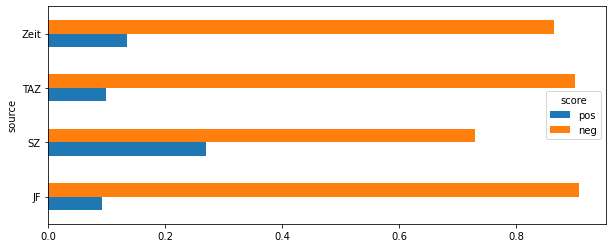

In [25]:
# But what does this all look like??
all_df.groupby('source').score.value_counts(normalize=True).unstack()[['pos', 'neg']].plot.barh(figsize=(10,4))
plt.show
# Huh, some expectations were met (JF has few postive articles), but then again so does TAZ...

In [26]:
# What does this look like in terms of numbers/percentages?
all_df.groupby('source').score.value_counts(normalize=True)

source  score
JF      neg      0.907895
        pos      0.092105
SZ      neg      0.729231
        pos      0.270769
TAZ     neg      0.900000
        pos      0.100000
Zeit    neg      0.864912
        pos      0.135088
Name: score, dtype: float64

In [27]:
all_df.groupby('source').score.value_counts()

source  score
JF      neg       69
        pos        7
SZ      neg      711
        pos      264
TAZ     neg       90
        pos       10
Zeit    neg      493
        pos       77
Name: score, dtype: int64

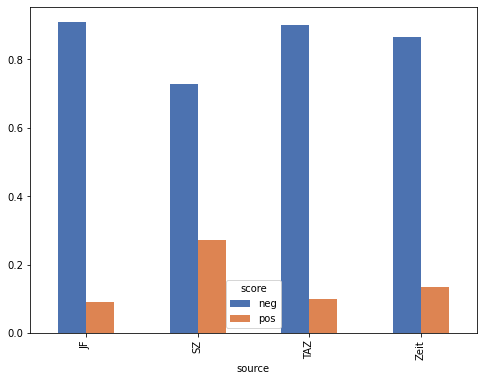

In [28]:
# Another way to vizualize
sns.set_palette('deep')
posneg_bysource = all_df.groupby('source').score.value_counts(normalize=True)
posneg_bysource

posneg_bysource.unstack(level=1).plot.bar(figsize=(8,6))
plt.show()

In [29]:
# What about change in sentiment over time? I only worked with Zeit for now because they have the most even dist
# and no variations in how the date is written
zeit_df_wsc = all_df[all_df['source'] == 'Zeit']
zeit_df_wsc

month_z = [date.split('-')[1] for date in zeit_df_wsc.date]
print(len(month_z))
zeit_df_wsc['month'] = month_z
zeit_df_wsc.tail()

573


,href,text,date,word_count,sent_count,toks,types,TTR,source,score,month
568,http://www.zeit.de/politik/deutschland/2015-01...,Am Mittwoch um 15.37 kommt Alexander Gauland g...,2015-01-08T16:00:49Z,893,45,1055,488,0.462559,Zeit,neg,01
569,http://www.zeit.de/2015/02/kreatives-berlin-to...,"Sie sagen, es sei Liebe. Als im Oktober 2014 d...",2015-01-08T09:01:28Z,705,50,825,462,0.560000,Zeit,pos,01
570,http://www.zeit.de/wirtschaft/2015-01/migratio...,"ZEIT ONLINE: Herr Brücker, zahlen die öffentli...",2015-01-06T13:36:03Z,668,44,767,374,0.487614,Zeit,neg,01
571,http://www.zeit.de/politik/deutschland/2015-01...,Wer ist Konrad Adam? Vor einigen Wochen hätte ...,2015-01-05T19:41:34Z,496,29,566,325,0.574205,Zeit,neg,01
572,http://www.zeit.de/gesellschaft/zeitgeschehen/...,"Erst die Blue Sky M mit fast 800 Menschen, dan...",2015-01-02T18:23:42Z,581,33,662,350,0.528701,Zeit,neg,01


In [30]:
# Not quite even dist, biit all months are accounted for
zeit_df_wsc['month'].value_counts()

09    81
10    79
11    69
12    68
08    51
05    44
01    40
02    32
04    32
06    28
07    28
03    21
Name: month, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

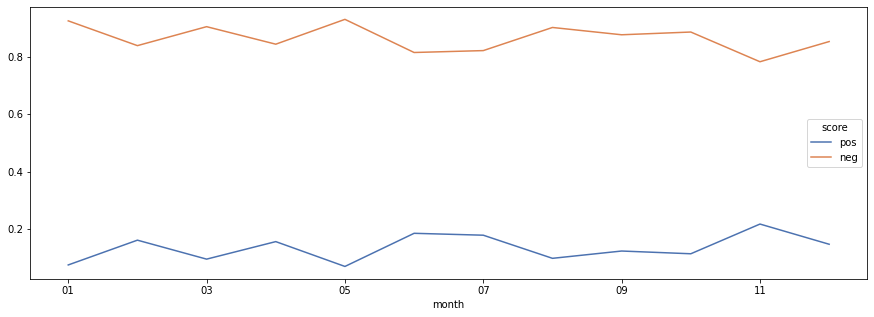

In [31]:
zeit_df_wsc.groupby('month').score.value_counts(normalize=True).unstack()[['pos', 'neg']].plot.line(figsize=(15,5))
plt.show

In [32]:
# April is when things really started to get crazy and the EU was trying to decide what to do with all the 
# incoming refugees, but I dont know of anything big that led to the dips in postivity. May seems an all time low... 
# Here is a general timeline from wikipedia: https://en.wikipedia.org/wiki/Timeline_of_the_European_migrant_crisis#2015

In [33]:
f = nlp('Flüchtlings, Flüchtlingen, Flüchtlinges, Flüchtlinge')
for token in f:
    print(token.lemma_)

Flüchtling
,
Flüchtling
,
Flüchtling
,
Flüchtling


In [96]:
scores_2 = {}
words = {}
#wd_sc = [()]
for url, doc in zip(url_lst, nlp.pipe(doc_lst)):
    w = [token.text for token in doc if not token.lemma_=='Flüchtling' if not token.is_stop if token._.sentiws is not None]
    y = [token._.sentiws for token in doc if not token.lemma_=='Flüchtling' if not token.is_stop if token._.sentiws is not None]
    #wd_sc.append(w, y)
    scores_2[url] = y
    words[url] = w

In [97]:
for k, v in scores_2.items():
    try:
        scores_2[k] = statistics.mean(v)
    except:
        scores_2[k] = 0.0
        pass

In [98]:
all_df['score2'] = all_df['href'].map(scores_2)
all_df['words'] = all_df['href'].map(words)
all_df.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score,score2,words
0,https://www.sueddeutsche.de/politik/migration-...,Berlin (dpa) - Die Bundesländer haben für die ...,"27. Dezember 2015, 2:45 Uhr",89,5,103,83,0.805825,SZ,neg,-0.117400,"[spezielle, befürchtet, ausreicht]"
1,https://www.sueddeutsche.de/politik/migration-...,Rom (dpa) - Im Mittelmeer vor Italien sind auc...,"26. Dezember 2015, 20:51 Uhr",62,4,72,56,0.777778,SZ,pos,0.004000,"[gerettet, koordinierten, Beteiligt, gerettet]"
2,https://www.sueddeutsche.de/kultur/rueckblick-...,1 / 12 Quelle: 20th Century Fox Südseefilme si...,"26. Dezember 2015, 17:57 Uhr",1818,87,2174,1004,0.461822,SZ,neg,-0.080904,"[schönsten, Spott, Bösartigkeit, auflösen, sch..."
3,https://www.sueddeutsche.de/politik/rueckblick...,Bei dem Blick zurück auf das Jahr 2015 stechen...,"26. Dezember 2015, 16:00 Uhr",451,28,512,312,0.609375,SZ,neg,-0.153719,"[Flucht, vertrieben, Kriege, menschenwürdiges,..."
4,https://www.sueddeutsche.de/politik/fluechtlin...,Nach einem Brandanschlag auf eine noch nicht f...,"26. Dezember 2015, 15:43 Uhr",387,26,451,274,0.607539,SZ,neg,-0.098771,"[fertige, Toleranz, Menschlichkeit, Brand, ver..."


In [173]:
all_df.sample(10)

,href,text,date,word_count,sent_count,toks,types,TTR,source,score,score2,words
368,https://www.sueddeutsche.de/karriere/arbeit-ju...,Hamburg (dpa/tmn) - In immer mehr Städten und ...,"19. November 2015, 9:53 Uhr",362,35,427,230,0.538642,SZ,neg,-0.030504,"[Wichtige, Experten, kümmern, Vorteil, Problem..."
34,http://www.zeit.de/politik/2015-12/syrien-tuer...,Die Menschenrechtsorganisation Amnesty Interna...,2015-12-16T02:13:38Z,366,19,417,235,0.563549,Zeit,neg,-0.173917,"[unbestimmte, Vorwurf, gezwungen, kritisiert, ..."
39,https://taz.de/Fluechtlinge-am-Hamburger-Haupt...,Täglich kommen 2.500 Flüchtlinge in die Hanses...,2015-09-18,1066,93,1307,588,0.449885,TAZ,neg,-0.003994,"[helfen, Hilfe, helfen, Ziel, richtigen, vermi..."
642,https://www.sueddeutsche.de/muenchen/freising/...,"Ein Dritschler ist im Bairischen ein Mensch, d...","29. Oktober 2015, 18:54 Uhr",732,55,864,439,0.508102,SZ,neg,-0.060688,"[stört, drängen, ungeduldiger, fürchten, Zerst..."
903,https://www.sueddeutsche.de/politik/migration-...,Erfurt (dpa) - Begleitet von einem Großaufgebo...,"8. Oktober 2015, 6:31 Uhr",93,6,103,80,0.776699,SZ,pos,0.226700,[nächsten]
280,https://www.sueddeutsche.de/politik/etat-2016-...,"Es ist nicht üblich, dass Haushaltsberatungen ...","27. November 2015, 19:25 Uhr",466,27,526,309,0.587452,SZ,neg,-0.020050,"[geführt, schloss, anvertrauen, Lob, glücklich..."
43,https://www.sueddeutsche.de/politik/sz-espress...,"Merkels Neujahrsansprache: ""Deutschland ist ei...","24. Dezember 2015, 10:59 Uhr",233,22,269,194,0.721190,SZ,neg,-0.117975,"[starkes, profitieren, erklärt, Verdächtige, G..."
213,https://www.sueddeutsche.de/wirtschaft/arbeits...,Die Bundesregierung will Flüchtlinge künftig e...,"3. Dezember 2015, 18:48 Uhr",107,7,123,89,0.723577,SZ,neg,-0.354900,"[Arbeitslosen, Arbeitslosen]"
63,http://www.zeit.de/politik/ausland/2015-12/slo...,Die Slowakei hat beim Europäischen Gerichtshof...,2015-12-02T12:03:39Z,374,25,422,249,0.590047,Zeit,neg,-0.025528,"[Klage, Klage, Möglichkeiten, reichere, hoffte..."
205,https://www.sueddeutsche.de/muenchen/freising/...,SPD-Kreisvorsitzender Peter Warlimont hat Baye...,"3. Dezember 2015, 18:50 Uhr",382,28,444,248,0.558559,SZ,neg,-0.013113,"[gestärkt, kümmern, Respekt, unbedachter, inte..."


In [41]:
def neg_pos(score):
    if score < 0.0:
        return 'neg'
    elif score > 0.0:
        return 'pos'
    else:
        return None


In [174]:
sc_wrds = all_df[['score2', 'words']]
sc_wrds.tail(20)
w = sc_wrds.words.tolist()
s = sc_wrds.score2.tolist()
z = list(zip(w,s))
#z

In [175]:
#all_df.score2 = all_df['score2'].map(lambda s: neg_pos(s))
#all_df.head(30)

In [43]:
all_df.groupby('source').score.value_counts()

source  score
JF      neg       69
        pos        7
SZ      neg      711
        pos      264
TAZ     neg       90
        pos       10
Zeit    neg      493
        pos       77
Name: score, dtype: int64

In [44]:
all_df.groupby('source').score2.value_counts()
# Huh, so gained one pos for JF, 17 for SZ, none for TAZ and 3 for Zeit

source  score2
JF      neg        68
        pos         8
SZ      neg       682
        pos       281
TAZ     neg        90
        pos        10
Zeit    neg       490
        pos        80
Name: score2, dtype: int64

In [45]:
all_df.info()
# But now there are a lot (12) of None...
# Does that mean that 12 only had flüchtling as a weighted word?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1731 entries, 0 to 572
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   href        1731 non-null   object 
 1   text        1731 non-null   object 
 2   date        1731 non-null   object 
 3   word_count  1731 non-null   int64  
 4   sent_count  1731 non-null   int64  
 5   toks        1731 non-null   int64  
 6   types       1731 non-null   int64  
 7   TTR         1731 non-null   float64
 8   source      1731 non-null   object 
 9   score       1721 non-null   object 
 10  score2      1709 non-null   object 
 11  words       1731 non-null   object 
dtypes: float64(1), int64(4), object(7)
memory usage: 175.8+ KB


In [54]:
pos2 = all_df[all_df.score2 == 'pos']
pos2.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score,score2,words
1,https://www.sueddeutsche.de/politik/migration-...,Rom (dpa) - Im Mittelmeer vor Italien sind auc...,"26. Dezember 2015, 20:51 Uhr",62,4,72,56,0.777778,SZ,pos,pos,"[gerettet, koordinierten, Beteiligt, gerettet]"
13,https://www.sueddeutsche.de/panorama/kirche-pa...,Rom (dpa) - Die Weihnachtsbotschaften der Kirc...,"26. Dezember 2015, 0:54 Uhr",81,5,91,73,0.802198,SZ,pos,pos,"[Konflikten, Nahen, Frieden, Heiligen, Gewalt,..."
14,https://www.sueddeutsche.de/politik/migration-...,Rom (dpa) - Die italienische Küstenwache hat a...,"25. Dezember 2015, 17:47 Uhr",75,5,83,66,0.795181,SZ,neg,pos,[gerettet]
22,https://www.sueddeutsche.de/leben/ehrenamtlich...,Als Deutschland im Sommer sein Willkommensfest...,"25. Dezember 2015, 9:16 Uhr",816,65,973,462,0.474820,SZ,pos,pos,"[feierte, feierte, tolle, bunte, kümmern, kurz..."
23,https://www.sueddeutsche.de/politik/migration-...,Mainz (dpa) - Die rheinland-pfälzische Ministe...,"25. Dezember 2015, 9:07 Uhr",199,15,238,151,0.634454,SZ,pos,pos,"[Bund, unterstützen, nächsten, Investitionen, ..."


In [58]:
neg2 = all_df[all_df.score2=='neg']
neg2.head()

,href,text,date,word_count,sent_count,toks,types,TTR,source,score,score2,words
0,https://www.sueddeutsche.de/politik/migration-...,Berlin (dpa) - Die Bundesländer haben für die ...,"27. Dezember 2015, 2:45 Uhr",89,5,103,83,0.805825,SZ,neg,neg,"[spezielle, befürchtet, ausreicht]"
2,https://www.sueddeutsche.de/kultur/rueckblick-...,1 / 12 Quelle: 20th Century Fox Südseefilme si...,"26. Dezember 2015, 17:57 Uhr",1818,87,2174,1004,0.461822,SZ,neg,neg,"[schönsten, Spott, Bösartigkeit, auflösen, sch..."
3,https://www.sueddeutsche.de/politik/rueckblick...,Bei dem Blick zurück auf das Jahr 2015 stechen...,"26. Dezember 2015, 16:00 Uhr",451,28,512,312,0.609375,SZ,neg,neg,"[Flucht, vertrieben, Kriege, menschenwürdiges,..."
4,https://www.sueddeutsche.de/politik/fluechtlin...,Nach einem Brandanschlag auf eine noch nicht f...,"26. Dezember 2015, 15:43 Uhr",387,26,451,274,0.607539,SZ,neg,neg,"[fertige, Toleranz, Menschlichkeit, Brand, ver..."
6,https://www.sueddeutsche.de/politik/migration-...,Mainz (dpa) - CDU-Vizechefin Julia Klöckner hä...,"26. Dezember 2015, 12:12 Uhr",87,5,107,84,0.785047,SZ,neg,neg,"[lückenlose, gefälscht, falschen, besteht]"


In [101]:
pos_wrds = pos2.words.tolist()
neg_wrds = neg2.words.tolist()
neg_w = [item for sublist in neg_wrds for item in sublist]
pos_w = [item for sublist in pos_wrds for item in sublist]
print(pos_w[:10])
print(neg_w[:10])

['gerettet', 'koordinierten', 'Beteiligt', 'gerettet', 'Konflikten', 'Nahen', 'Frieden', 'Heiligen', 'Gewalt', 'Hoffnung']
['spezielle', 'befürchtet', 'ausreicht', 'schönsten', 'Spott', 'Bösartigkeit', 'auflösen', 'schenkt', 'unruhigen', 'Frust']


In [102]:
from collections import Counter
counts = Counter(pos_w)
mc_pos = counts.most_common(50)
print(mc_pos)

[('helfen', 86), ('kurzen', 72), ('lernen', 57), ('nächsten', 48), ('Hilfe', 45), ('erklärt', 44), ('Unterstützung', 42), ('Einheit', 41), ('Engagement', 38), ('unterstützen', 38), ('schaffen', 36), ('Flucht', 35), ('Ziel', 34), ('guten', 34), ('Ausbildung', 32), ('kümmern', 30), ('erhalten', 30), ('unterstützt', 28), ('Problem', 27), ('Bildung', 27), ('Bund', 26), ('Probleme', 26), ('Erfolg', 26), ('erklärte', 25), ('größte', 24), ('integrieren', 24), ('Erfahrungen', 23), ('Glück', 23), ('erreichen', 22), ('hilft', 22), ('Zusammenarbeit', 22), ('Möglichkeit', 22), ('Festakt', 22), ('aktuellen', 21), ('Werte', 20), ('Möglichkeiten', 20), ('miteinander', 20), ('Freunde', 19), ('Herausforderung', 19), ('Anteil', 19), ('bessere', 18), ('Ruhe', 18), ('Sicherheit', 18), ('gerettet', 17), ('gelernt', 17), ('Liebe', 17), ('Krieg', 17), ('Spenden', 17), ('hohen', 17), ('Freude', 17)]


In [103]:
c = Counter(neg_w)
mc_neg = c.most_common(50)
print(mc_neg)
# Second most common is the first most common in pos...

[('kurzen', 464), ('Problem', 233), ('schaffen', 224), ('Angst', 220), ('Krieg', 218), ('Hilfe', 201), ('Kritik', 178), ('Probleme', 171), ('Gewalt', 171), ('erklärt', 165), ('helfen', 164), ('Flucht', 161), ('Schutz', 155), ('Unterstützung', 135), ('Sicherheit', 131), ('erhalten', 130), ('Lösung', 130), ('nächsten', 129), ('erklärte', 120), ('Kampf', 118), ('Ziel', 117), ('Krise', 112), ('Bund', 110), ('erreichen', 109), ('Streit', 108), ('führen', 104), ('führt', 95), ('Not', 92), ('Terror', 90), ('Gefahr', 88), ('Verantwortung', 88), ('Sorgen', 88), ('Solidarität', 87), ('aktuellen', 84), ('Freiheit', 82), ('kritisiert', 80), ('verletzt', 79), ('hohen', 79), ('Möglichkeit', 79), ('illegale', 79), ('Tod', 79), ('Anspruch', 79), ('alten', 78), ('Bildung', 78), ('geführt', 77), ('Werte', 77), ('Nähe', 76), ('kritisierte', 76), ('lösen', 76), ('Kraft', 74)]


In [115]:
neg50 = []
for w,c in mc_neg:
    neg50.append(w)
    
print(dir(token._.sentiws))    

for token in nlp.pipe(neg50):
    print(token.text, token._.sentiws)

['__abs__', '__add__', '__and__', '__bool__', '__ceil__', '__class__', '__delattr__', '__dir__', '__divmod__', '__doc__', '__eq__', '__float__', '__floor__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getnewargs__', '__gt__', '__hash__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__le__', '__lshift__', '__lt__', '__mod__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__', '__rdivmod__', '__reduce__', '__reduce_ex__', '__repr__', '__rfloordiv__', '__rlshift__', '__rmod__', '__rmul__', '__ror__', '__round__', '__rpow__', '__rrshift__', '__rshift__', '__rsub__', '__rtruediv__', '__rxor__', '__setattr__', '__sizeof__', '__str__', '__sub__', '__subclasshook__', '__truediv__', '__trunc__', '__xor__', 'bit_length', 'conjugate', 'denominator', 'from_bytes', 'imag', 'numerator', 'real', 'to_bytes']
kurzen True
Problem True
schaffen True
Angst True
Krieg True
Hilfe True
Kritik True
Probleme True
Gew

In [117]:
from nltk import word_tokenize
import numpy as np
words_n = np.concatenate(np.array([word_tokenize(r) for r in neg2['text'].values]))
words_n

array(['Berlin', '(', 'dpa', ..., 'nie', 'zuvor', '.'], dtype='<U98')

In [137]:
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, BigramCollocationFinder, TrigramCollocationFinder

trigram_measures = TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(words_n)

finder.apply_freq_filter(4) 
finder.nbest(trigram_measures.pmi, 10)  

[('Noir', 'Hannes', 'Hintermeier'),
 ('Polar', 'Noir', 'Hannes'),
 ('BR', 'Gunter', 'Blank'),
 ('Literaturkritikerin', 'Ingeborg', 'Sperl'),
 ('Chaudhry', 'Nisar', 'Khan'),
 ('Literaturkritikerin', 'Elmar', 'Krekeler'),
 ('+', 'Verleugnung', '='),
 ('Offshore', 'Aid', 'Station'),
 ('Verleugnung', '=', 'Korruption'),
 ('Ban', 'Ki', 'Moon')]

In [148]:
all_words = all_df.groupby('source').apply(
    lambda df: np.concatenate(np.array([word_tokenize(r) for r in df['text'].values])))



def bigramify(words):
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(3)
    return finder.nbest(bigram_measures.pmi, 10)

all_bigrams = all_words.map(bigramify)
all_bigrams.head()

source
JF      [(Le, Pen), (Lega, Nord), (Ralf, Stegner), (Sa...
SZ      [(Ai, Weiwei), (Annett, Scheffel), (Cathrin, K...
TAZ     [(Hartz, IV), (Ovcha, Kupel), (Sri, Lanka), (e...
Zeit    [(Adamsbergs, Brigade), (AgenturchefinAnnett, ...
dtype: object

In [162]:
ugh = all_df.text.map(lambda x: nltk.word_tokenize(x))
ughh = [item for sublist in ugh for item in sublist]

In [171]:
#corpus = nltk.Text(text) 
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tri_finder = TrigramCollocationFinder.from_words(ughh)
# Only trigrams that appear 3+ times
tri_finder.apply_freq_filter(3)
# Only the ones containing my word
my_filter = lambda *w: 'Flüchtling' not in w
tri_finder.apply_ngram_filter(my_filter)

print(tri_finder.nbest(trigram_measures.pmi, 20))

[('keinen', 'einzigen', 'Flüchtling'), ('als', 'Flüchtling', 'getarnt'), ('Schutzstatus', 'als', 'Flüchtling'), ('als', 'Flüchtling', 'anerkannt'), ('Attentäter', 'als', 'Flüchtling'), ('Flüchtling', ')', 'registriert'), ('anerkannter', 'Flüchtling', '.'), ('Oktober', 'als', 'Flüchtling'), ('mit', 'jedem', 'Flüchtling'), ('„', 'Flüchtling', '“'), ('Ein', 'Flüchtling', 'aus'), ('Flüchtling', 'aus', 'Syrien'), ('Wenn', 'ein', 'Flüchtling'), (':', 'Ein', 'Flüchtling'), ('muss', 'ein', 'Flüchtling'), ('wenn', 'ein', 'Flüchtling'), ('Flüchtling', 'nach', 'Deutschland'), ('als', 'Flüchtling', 'aus'), ('(', 'als', 'Flüchtling'), ('als', 'Flüchtling', ')')]


In [172]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tri_finder = TrigramCollocationFinder.from_words(ughh)
# Only trigrams that appear 3+ times
tri_finder.apply_freq_filter(3)
# Only the ones containing my word
my_filter2 = lambda *w: 'Flüchtlingen' not in w
tri_finder.apply_ngram_filter(my_filter2)

print(tri_finder.nbest(trigram_measures.pmi, 20))

[('unbegleiteten', 'minderjährigen', 'Flüchtlingen'), ('160', '000', 'Flüchtlingen'), ('gegenüber', 'muslimischen', 'Flüchtlingen'), ('Flüchtlingen', 'durch', 'wirksame'), ('Rekordzahl', 'von', 'Flüchtlingen'), ('Durchwinkens', 'von', 'Flüchtlingen'), ('Andrangs', 'von', 'Flüchtlingen'), ('Umverteilung', 'von', 'Flüchtlingen'), ('Flüchtlingen', 'beizustehen', 'und'), ('und', 'Flüchtlingen', 'beizustehen'), ('Aufnahme', 'von', 'Flüchtlingen'), ('Zuzug', 'von', 'Flüchtlingen'), ('Zustrom', 'von', 'Flüchtlingen'), ('Einzug', 'von', 'Flüchtlingen'), ('Zuzugs', 'von', 'Flüchtlingen'), ('Unterbringung', 'von', 'Flüchtlingen'), ('von', '120.000', 'Flüchtlingen'), ('Zustrom', 'an', 'Flüchtlingen'), ('Umgang', 'mit', 'Flüchtlingen'), ('Behandlung', 'von', 'Flüchtlingen')]


In [170]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tri_finder = TrigramCollocationFinder.from_words(ughh)
# Only trigrams that appear 3+ times
tri_finder.apply_freq_filter(3)
# Only the ones containing my word
my_filter3 = lambda *w: 'Flüchtlinge' not in w
tri_finder.apply_ngram_filter(my_filter3)

print(tri_finder.nbest(trigram_measures.pmi, 20))

[('Unbegleitete', 'minderjährige', 'Flüchtlinge'), ('ankommenden', 'Flüchtlinge', 'sinke'), ('Flüchtlinge', 'ungewöhnlich', 'gewaltsam'), ('wartenden', 'Flüchtlinge', 'aufbauen'), ('unbegleitete', 'minderjährige', 'Flüchtlinge'), ('Schutzstatus', 'syrischer', 'Flüchtlinge'), ('syrischer', 'Flüchtlinge', 'einzuschränken'), ('unbegleiteten', 'minderjährigen', 'Flüchtlinge'), ('Kontingente', 'syrischer', 'Flüchtlinge'), ('unbegrenzt', 'Flüchtlinge', 'aufnehmen'), ('Integration', 'Hunderttausender', 'Flüchtlinge'), ('letzten', 'wartenden', 'Flüchtlinge'), ('Status', 'syrischer', 'Flüchtlinge'), ('gegen', 'Flüchtlinge', 'gehetzt'), ('Sommer', 'Hunderttausende', 'Flüchtlinge'), ('Thema', 'Flüchtlinge', 'geschlagen'), ('syrische', 'Flüchtlinge', 'aufgenommen'), ('2,5', 'Millionen', 'Flüchtlinge'), ('Schutz', 'syrischer', 'Flüchtlinge'), ('Aufnahme', 'syrischer', 'Flüchtlinge')]


In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [132]:
all_df = all_df.dropna()
X = all_df.text
y = all_df.score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

nbmodel = make_pipeline(TfidfVectorizer(max_features=1500), MultinomialNB())
nbmodel.fit(X_train, y_train)
plabels = nbmodel.predict(X_test)
print("Here's how it did:")
print(accuracy_score(y_test, plabels))

Here's how it did:
0.7913043478260869


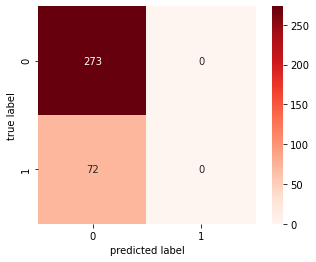

In [133]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, plabels)
sns.heatmap(mat, square=True, annot=True, fmt='d', cmap="Reds")
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()